<a href="https://colab.research.google.com/github/whitejetyeh/RBMIsing/blob/master/Temp_Classifier(June_19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Temperature Classifier
With dataset from groups of spin distributions at different temperatures, this neural network, Temp_Classifier is trained to classify spin distributions into given temperature labels. Spin distributions are generated from Markov-Chain-Monte-Carlo Ising Model on on a $N_s$ by $N_s$ grid.


Temp_Classifier can be pretty accurate 98+% with 1. enough neurons and layers, 2. finer grid, and 3. large gaps between temp labels. The last two points come from the nature of stochastic distributions, where we can spot identical spin distributions at different temperatures on a finite dimensional grid.


2D Ising model has the critical temperature $T_C\approx 2.27$. Below or above $T_C$, the system is in the ferromagnetic phase or the paramagnetic phase. The clear visual feature difference is the characteristic length, which refers to the size of a group of the same spin on the grid. At lower temperature, one spots larger groups of the same spin while up/down spins are much uniformly mixed up at higher temperature. Spin data in five temp_labels (0.27, 1.27, 2.27, 3.27, 4.27) are used here. 

Temp_Classifiers are named by $(N_s^2, N_{h}^{(1)}, N_{h}^{(2)},...,N_{l})$, where $(N_s, N_h^{(i)}, N_l)$ refer to (# of spins per dim, # of neurons on the i-th hidden layer, # of temp labels). One can easily build and test various temp_classifiers in different layers with **keras** in the following code. The accuracy of few classifiers are listed below.
$$\begin{align*}
\textrm{temp_classifier}&&\textrm{test accuracy   }&&\textrm{train accuracy}\\
(20^2,512,1024,5) && 0.76 && 0.91\\
(20^2,512,1024,3) && 0.98 && 1\\
(10^2,256,512,3) && 0.97 && 0.99\\
(10^2,256,512,5) && 0.64 && 0.81 \end{align*}$$

Temp_classifier $(10^2,256,512,5)$ is presented below, and we can see how overlapped distributions in different labels blur the classifier and limit the accuracy.

## Acquire data


1.   read data from google drive
2.   reshape and label data



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import libraries needed for the computation

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import os.path

print(tf.__version__)



1.14.0-rc1


The following code loads and processes raw data of spin distributions, which come from 
[MCMC Ising Model](https://drive.google.com/open?id=1GTzxGebfb-vao0J4q_CzSwC3SPmWakAd).

Raw data in each csv file labeled by temperature save 2000 samples of spin distribution on a $N_s$ by $N_s$ grid in the shape of $(2000*N_s,N_s)$, and they need to be reshaped into $(2000,N_s,N_s)$ for **Keras** to read.

Train_data and test_data are two independent datasets consisted of stacked up raw data. Train_data is randomly shuffled for training the model so the gradient descent method will less likely be stuck at the local minima, and test_data is for validation.

In [0]:
# given temperature labels from data set
temperatures=[0.27, 1.27, 2.27, 3.27, 4.27]
#temperatures=[0.27, 2.27, 4.27]

# Load spin data from CSV file
def acquire_spin_data(file, dataset):    
    raw_data = np.loadtxt(file,delimiter=",")
    raw_data = (raw_data+1)/2 # scale data from spin=(1,-1) to (1,0)
    raw_data=raw_data.reshape((2000,10,10)) # reshape to 2k data of 10^2 grid
    #raw_data=raw_data.reshape((2000,20,20)) # reshape to 2k data of 20^2 grid
    # tensor_util.py in tf takes only plain python lists or tuples but not numpy arrays
    raw_data=raw_data.astype(np.float32).tolist() 
    dataset.extend(raw_data)

train_data, test_data = [], []
train_labels, test_labels = [], []
ind = 0 # counter for the labels
for temp in temperatures:
    train_file = '/content/gdrive/My Drive/IsingModel/training2k/t='+str(temp)+'.csv'
    test_file = '/content/gdrive/My Drive/IsingModel/validation2k/t='+str(temp)+'.csv'
    acquire_spin_data(train_file, train_data)
    acquire_spin_data(test_file, test_data)
    train_labels += [ind]*2000
    test_labels += [ind]*2000
    ind += 1

# shuffle dataset and labels simutaneously
# array indexing
def unity_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

train_data,train_labels=unity_shuffled_copies(np.array(train_data),np.array(train_labels))


## Explore data
Take a look at spin distributions from the training dataset.
16 spin distributions with their temperatures denoted below are presented.

It's clear to see the larger characteristic length at lower temperature, i.e. larger block of same spin in the plot.

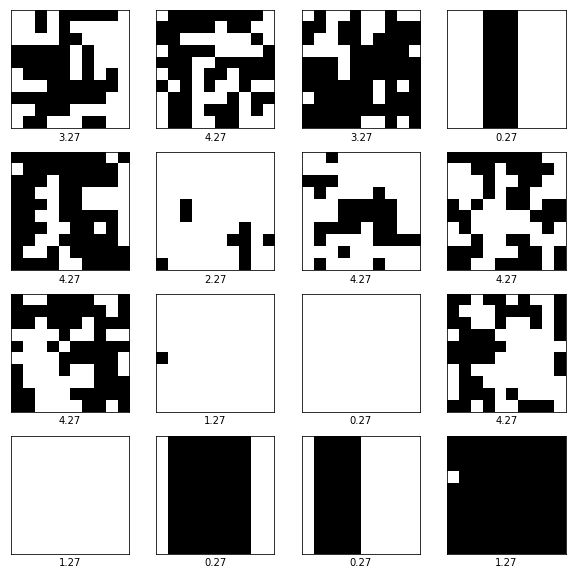

In [0]:
# plot 16 spin distributions from the training dataset
np.random.seed(1)
ind=np.random.randint(0,1999) #pick random 16 data
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[ind+i], cmap=plt.cm.binary)
    plt.xlabel(temperatures[train_labels[ind+i]])
plt.show()

## Overlapped distribution figures


Notice that we might find the same spin distribution in two temperature classes. 
In particular, it's easy to find the all up/down (all black or white) distribution can appear at both t=0.27 and t=1.27. The overlapped distributions limit the accuracy of the classifier on a finite grid, and therefore the temperature difference between labels can't be too small. In this case of 10 by 10 grid, we can only specify $t=\{0.27,1.27,2.27,3.27,4.27\}$ with accuracy 64%, but the accuracy becomes 97% with less labels $t=\{0.27,2.27,4.27\}$.

# Neural Network


1.   visible layer: 100 neurons for spins on the 10 by 10 grid (upgrated to 20 x 20)
2.   hidden layer: 64 neurons with activation function = tanh
3.   output layer: 5 neurons for 5 temperatures with activation function = softmax
4.   cost function: cross entropy
5.   gradient descent: learning rate=0.1 for 7000 epochs


Options for the optimizer could be adam, sgd, RMSprop,...etc; computation time and accuracy are not significantly different. Wtih 70 epochs, the accuracy in the training data can achieve near 90%, and the accuracy in the validation data is about 60~70%. 
Here, adam converges faster, but sgd achieves higher accuracy. Since the number of required epochs is quite small, we prefer sgd over adam.


## Model Construction
This example has four layers. First input layer takes flatten spin distributions on a 10 by 10 grid. The next two layers have 256 and 512 neurons with activation function **relu**. One can change relu to tanh or sigmoid, and the difference is insignificant. The last layer with **softmax** outputs the probabilities of corresponding temp labels. Finally, the loss function is **sgd**. In this case, sgd works better than the usual adam.

In [0]:
# set up the layers
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(10, 10)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(5, activation=tf.nn.softmax)
])

# compile the model
model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Model Training

The training doesn't take longer than a minute. By looking at accuracy of each epoch, 70 epochs is enough to reach a steady result with a small fluctuation.

In [0]:
# train the model in numpy arrays
start = time.time() # timing training process
model.fit(train_data,train_labels, epochs=70)
end = time.time() # timing training process
print('training time takes ',end-start)

# evaluate accuracy
test_loss, test_acc = model.evaluate(np.array(test_data),test_labels)
print('Test accuracy:', test_acc)

Epoch 1/70
10000/10000 [==============================] - 1s 63us/sample - loss: 1.4650 - acc: 0.3665
Epoch 2/70
10000/10000 [==============================] - 1s 60us/sample - loss: 1.3178 - acc: 0.4088
Epoch 3/70
10000/10000 [==============================] - 1s 58us/sample - loss: 1.2328 - acc: 0.4405
Epoch 4/70
10000/10000 [==============================] - 1s 60us/sample - loss: 1.1572 - acc: 0.4732
Epoch 5/70
10000/10000 [==============================] - 1s 60us/sample - loss: 1.0878 - acc: 0.5237
Epoch 6/70
10000/10000 [==============================] - 1s 61us/sample - loss: 1.0205 - acc: 0.5674
Epoch 7/70
10000/10000 [==============================] - 1s 63us/sample - loss: 0.9579 - acc: 0.5984
Epoch 8/70
10000/10000 [==============================] - 1s 60us/sample - loss: 0.9021 - acc: 0.6158
Epoch 9/70
10000/10000 [==============================] - 1s 62us/sample - loss: 0.8533 - acc: 0.6312
Epoch 10/70
10000/10000 [==============================] - 1s 60us/sample - loss: 

Save the trained model

In [0]:
# save model and architecture to single file
save_path = '/content/gdrive/My Drive/IsingModel/'
model_name = 'temp_classifier_100_256_512_5.h5'
model.save(os.path.join(save_path, model_name))

## Prediction

One can load a trained temp_classifier as the following.

In [0]:
# load model and architecture from a single file
save_path = '/content/gdrive/My Drive/IsingModel/'
model_name = 'temp_classifier_100_256_512_5.h5'
model = keras.models.load_model(os.path.join(save_path, model_name))

model.summary() # print the architecture of the model

# evaluate accuracy
test_loss, test_acc = model.evaluate(np.array(test_data),test_labels)
print('Test accuracy:', test_acc)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 160,005
Trainable params: 160,005
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 47us/sample - loss: 0.7780 - acc: 0.6421
Test accuracy: 0.6421


Given data of spin distributions, temp_classifier can predict the corresponding temperatures as the following.

[[2.7254787e-08 8.9285886e-06 4.6767202e-01 5.0977039e-01 2.2548644e-02]]


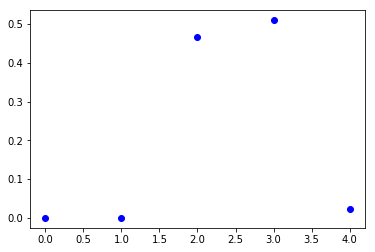

Predict temperature is 3.27
Data temperature is 2.27


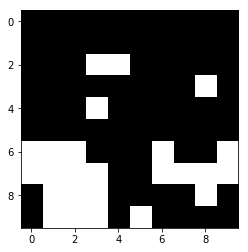

In [0]:
# make a prediction
TempClass = 2 # choose a temp label
chosen_index = TempClass*2000+np.random.randint(0,1999) # randomly pick a sample

img = np.array(test_data[chosen_index])
img = (np.expand_dims(img,0)) # Add the image to a batch where it's the only member.
predictions = model.predict(img)

#plot_value_array(0, predictions, test_labels[chosen_index])
#_ = plt.xticks(range(5), temperatures, rotation=45)

print(predictions) # probability distribution
plt.plot(range(len(temperatures)),predictions[0],'ob')
plt.show()
print('Predict temperature is '+
      str(temperatures[np.argmax(predictions)])) # prediction

print('Data temperature is '+str(temperatures[test_labels[chosen_index]]))# fact
plt.figure()
plt.imshow(test_data[chosen_index], cmap=plt.cm.binary)
plt.show()